In [1]:
from tools_stance import * 
from models import *
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

path="../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


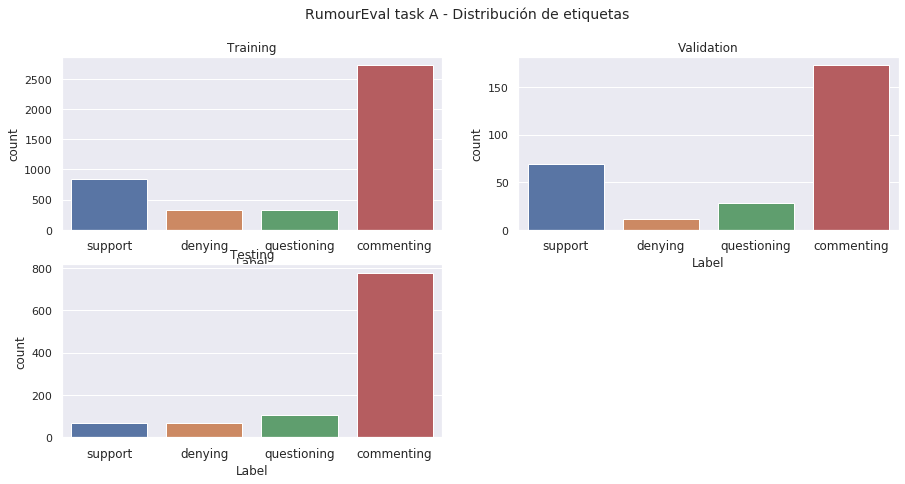

In [2]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
j=220
labs=['support', 'denying', 'questioning', 'commenting']
data=[train['Label'], val['Label'], test["Label"]]
name=["Training", "Validation", "Testing"]
for i in range(3):
    j+=1
    h=fig.add_subplot(j)
    ax= sns.countplot(data[i], order=labs)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    h.title.set_text(str(name[i]))

fig.suptitle("RumourEval task A - Distribución de etiquetas", fontsize=14)
plt.show()

In [3]:
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [5]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(1193513, 200)

In [6]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [1.25980975 3.18168168 3.21060606 0.38752743]


In [7]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [8]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [9]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [10]:
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [11]:
x_train.shape

(4238, 37, 200)

In [12]:
x_test.shape

(1021, 37, 200)

## 0.15

In [13]:
def load_data(path_to_data):
    macro_augmented = np.load(path_to_data, allow_pickle=True)
    np.random.shuffle(macro_augmented)

    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    print (np.unique(labels_train), type(labels_train))
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    sentences = tws_train
    n_labels = labels_train.copy()

    input_ids = []
    for sent in sentences:
        encoded_sent = [] 
        for wd in sent:
            try:
                encoded_sent.append(token_2_idx[wd])
            except:
                continue
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], emb))
    j=0
    for in_id in input_ids:
        x_train[j]=EMB_matrix[in_id]
        j+=1

    return x_train, y_train, n_labels, class_weights


In [14]:
k=2

In [15]:
x_train, y_train, n_labels, class_weights = load_data('../Datasets/CSV_Stance/Aumento_ofi/balance_GloVe_15_'+str(k)+'_run.npy')

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\n\n -------------------- Entrenando exec", i," -------------------- \n")
    cnn1=create_cnn1(x_train.shape[1:])
    #cnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn1_'+str(i)+'-exec.h5')   
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    #cnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    #rnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn3=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

------ Training ------
Accuracy cnn1 : 0.795
F1-score macro cnn1 : 0.791
F1-score None cnn1 : [0.691 0.901 0.881 0.692]

------ Validation ------
Accuracy cnn1 : 0.630
F1-score macro cnn1 : 0.540
F1-score None cnn1 : [0.434 0.476 0.515 0.734]

------ Testing ------
Accuracy cnn1 : 0.645
F1-score macro cnn1 : 0.378
F1-score None cnn1 : [0.068 0.207 0.466 0.772]

------ Training ------
Accuracy cnn2 : 0.775
F1-score macro cnn2 : 0.768
F1-score None cnn2 : [0.67  0.864 0.899 0.639]

------ Validation ------
Accuracy cnn2 : 0.616
F1-score macro cnn2 : 0.509
F1-score None cnn2 : [0.551 0.235 0.545 0.703]

------ Testing ------
Accuracy cnn2 : 0.578



------ Testing ------
Accuracy rnn2 : 0.500
F1-score macro rnn2 : 0.355
F1-score None rnn2 : [0.126 0.224 0.436 0.635]

------ Training ------
Accuracy rnn3 : 0.603
F1-score macro rnn3 : 0.590
F1-score None rnn3 : [0.601 0.58  0.72  0.459]

------ Validation ------
Accuracy rnn3 : 0.491
F1-score macro rnn3 : 0.437
F1-score None rnn3 : [0.545 0.154 0.51  0.54 ]

------ Testing ------
Accuracy rnn3 : 0.407
F1-score macro rnn3 : 0.303
F1-score None rnn3 : [0.097 0.191 0.408 0.516]


 -------------------- Entrenando exec 4  -------------------- 


------ Training ------
Accuracy cnn1 : 0.837
F1-score macro cnn1 : 0.837
F1-score None cnn1 : [0.792 0.91  0.918 0.727]

------ Validation ------
Accuracy cnn1 : 0.698
F1-score macro cnn1 : 0.611
F1-score None cnn1 : [0.626 0.421 0.633 0.763]

------ Testing ------
Accuracy cnn1 : 0.679
F1-score macro cnn1 : 0.439
F1-score None cnn1 : [0.162 0.229 0.568 0.796]

------ Training ------
Accuracy cnn2 : 0.809
F1-score macro cnn2 : 0.815
F1-score Non

In [16]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5 , "desvest: ",np.std(accs[key]))

--------- Usando contexto positivo y negativo obligadamente ---------

0.15 Clase Ponderado - F1-score promedio para cnn1 : [0.11  0.21  0.557 0.809]
0.15 Clase Ponderado - F1-score promedio para cnn2 : [0.087 0.212 0.507 0.77 ]
0.15 Clase Ponderado - F1-score promedio para rnn1 : [0.166 0.199 0.522 0.578]
0.15 Clase Ponderado - F1-score promedio para rnn2 : [0.182 0.2   0.48  0.607]
0.15 Clase Ponderado - F1-score promedio para rnn3 : [0.138 0.197 0.401 0.454]

0.15 Clase Ponderado - F1-score macro promedio para cnn1 : 0.4213775188655012 desvest:  0.022240474415844584
0.15 Clase Ponderado - F1-score macro promedio para cnn2 : 0.39409956834969917 desvest:  0.033129712165609275
0.15 Clase Ponderado - F1-score macro promedio para rnn1 : 0.3661700057521361 desvest:  0.04228463572663225
0.15 Clase Ponderado - F1-score macro promedio para rnn2 : 0.36701091970094823 desvest:  0.023905139651485906
0.15 Clase Ponderado - F1-score macro promedio para rnn3 : 0.2972959862279464 desvest:  0.025600

## 0.5

In [17]:
x_train, y_train, n_labels, class_weights = load_data('../Datasets/CSV_Stance/Aumento_ofi/balance_GloVe_50_'+str(k)+'_run.npy')

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\n\n -------------------- Entrenando exec", i," -------------------- \n")
    cnn1=create_cnn1(x_train.shape[1:])
    #cnn1=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn1_'+str(i)+'-exec.h5')   
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    #cnn2=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    #rnn1=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn2=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn3=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 


------ Training ------
Accuracy cnn1 : 0.786
F1-score macro cnn1 : 0.794
F1-score None cnn1 : [0.755 0.82  0.909 0.69 ]

------ Validation ------
Accuracy cnn1 : 0.705
F1-score macro cnn1 : 0.586
F1-score None cnn1 : [0.587 0.333 0.64  0.785]

------ Testing ------
Accuracy cnn1 : 0.708
F1-score macro cnn1 : 0.419
F1-score None cnn1 : [0.143 0.13  0.579 0.824]

------ Training ------
Accuracy cnn2 : 0.763
F1-score macro cnn2 : 0.756
F1-score None cnn2 : [0.633 0.805 0.919 0.667]

------ Validation ------
Accuracy cnn2 : 0.658
F1-score macro cnn2 : 0.532
F1-score None cnn2 : [0.565 0.19  0.609 0.765]

------ Testing ------
Accuracy cnn2 : 0.633
F1-score macro cnn2 : 0.425
F1-score None cnn2 : [0.078 0.246 0.617 0.758]

------ Training ------
Accuracy rnn1 : 0.615
F1-score macro rnn1 : 0.605
F1-score None rnn1 : [0.605 0.54  0.745 0.529]

------ Validation -


------ Testing ------
Accuracy cnn2 : 0.690
F1-score macro cnn2 : 0.403
F1-score None cnn2 : [0.043 0.206 0.556 0.806]

------ Training ------
Accuracy rnn1 : 0.554
F1-score macro rnn1 : 0.528
F1-score None rnn1 : [0.655 0.416 0.638 0.405]

------ Validation ------
Accuracy rnn1 : 0.441
F1-score macro rnn1 : 0.366
F1-score None rnn1 : [0.527 0.118 0.38  0.44 ]

------ Testing ------
Accuracy rnn1 : 0.358
F1-score macro rnn1 : 0.282
F1-score None rnn1 : [0.203 0.149 0.331 0.443]

------ Training ------
Accuracy rnn2 : 0.740
F1-score macro rnn2 : 0.723
F1-score None rnn2 : [0.488 0.85  0.895 0.659]

------ Validation ------
Accuracy rnn2 : 0.605
F1-score macro rnn2 : 0.456
F1-score None rnn2 : [0.404 0.103 0.605 0.714]

------ Testing ------
Accuracy rnn2 : 0.640
F1-score macro rnn2 : 0.352
F1-score None rnn2 : [0.    0.188 0.448 0.774]

------ Training ------
Accuracy rnn3 : 0.603
F1-score macro rnn3 : 0.588
F1-score None rnn3 : [0.64  0.579 0.759 0.375]

------ Validation ------
Accur

In [18]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.5 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.5 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.5 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5 , "desvest: ",np.std(accs[key]))

--------- Usando contexto positivo y negativo obligadamente ---------

0.5 Clase Ponderado - F1-score promedio para cnn1 : [0.09  0.22  0.565 0.78 ]
0.5 Clase Ponderado - F1-score promedio para cnn2 : [0.084 0.219 0.588 0.794]
0.5 Clase Ponderado - F1-score promedio para rnn1 : [0.185 0.159 0.326 0.371]
0.5 Clase Ponderado - F1-score promedio para rnn2 : [0.121 0.184 0.454 0.62 ]
0.5 Clase Ponderado - F1-score promedio para rnn3 : [0.154 0.187 0.479 0.445]

0.5 Clase Ponderado - F1-score macro promedio para cnn1 : 0.41366211690222465 desvest:  0.017775100126088673
0.5 Clase Ponderado - F1-score macro promedio para cnn2 : 0.42125668310191966 desvest:  0.011310655395884722
0.5 Clase Ponderado - F1-score macro promedio para rnn1 : 0.26044313744757525 desvest:  0.05205669900099739
0.5 Clase Ponderado - F1-score macro promedio para rnn2 : 0.34463630433744524 desvest:  0.010565505751329762
0.5 Clase Ponderado - F1-score macro promedio para rnn3 : 0.316446396508811 desvest:  0.068754266110063

## 0.85

In [19]:
x_train, y_train, n_labels, class_weights = load_data('../Datasets/CSV_Stance/Aumento_ofi/balance_GloVe_85_'+str(k)+'_run.npy')

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\n\n -------------------- Entrenando exec", i," -------------------- \n")
    cnn1=create_cnn1(x_train.shape[1:])
    #cnn1=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn1_'+str(i)+'-exec.h5')   
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    #cnn2=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    #rnn1=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn2=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn3=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 


------ Training ------
Accuracy cnn1 : 0.810
F1-score macro cnn1 : 0.806
F1-score None cnn1 : [0.674 0.879 0.932 0.738]

------ Validation ------
Accuracy cnn1 : 0.662
F1-score macro cnn1 : 0.528
F1-score None cnn1 : [0.423 0.276 0.655 0.759]

------ Testing ------
Accuracy cnn1 : 0.683
F1-score macro cnn1 : 0.406
F1-score None cnn1 : [0.039 0.218 0.565 0.802]

------ Training ------
Accuracy cnn2 : 0.783
F1-score macro cnn2 : 0.780
F1-score None cnn2 : [0.672 0.822 0.9   0.728]

------ Validation ------
Accuracy cnn2 : 0.651
F1-score macro cnn2 : 0.527
F1-score None cnn2 : [0.512 0.171 0.679 0.745]

------ Testing ------
Accuracy cnn2 : 0.654
F1-score macro cnn2 : 0.397
F1-score None cnn2 : [0.042 0.187 0.577 0.781]

------ Training ------
Accuracy rnn1 : 0.682
F1-score macro rnn1 : 0.684
F1-score None rnn1 : [0.657 0.703 0.797 0.579]

------ Validation -


------ Testing ------
Accuracy cnn2 : 0.746
F1-score macro cnn2 : 0.375
F1-score None cnn2 : [0.078 0.121 0.448 0.854]

------ Training ------
Accuracy rnn1 : 0.524
F1-score macro rnn1 : 0.484
F1-score None rnn1 : [0.522 0.516 0.673 0.227]

------ Validation ------
Accuracy rnn1 : 0.320
F1-score macro rnn1 : 0.322
F1-score None rnn1 : [0.516 0.139 0.375 0.258]

------ Testing ------
Accuracy rnn1 : 0.226
F1-score macro rnn1 : 0.195
F1-score None rnn1 : [0.066 0.158 0.337 0.22 ]

------ Training ------
Accuracy rnn2 : 0.789
F1-score macro rnn2 : 0.790
F1-score None rnn2 : [0.736 0.811 0.883 0.73 ]

------ Validation ------
Accuracy rnn2 : 0.651
F1-score macro rnn2 : 0.459
F1-score None rnn2 : [0.543 0.    0.548 0.746]

------ Testing ------
Accuracy rnn2 : 0.692
F1-score macro rnn2 : 0.389
F1-score None rnn2 : [0.106 0.199 0.435 0.814]

------ Training ------
Accuracy rnn3 : 0.609
F1-score macro rnn3 : 0.590
F1-score None rnn3 : [0.632 0.617 0.741 0.37 ]

------ Validation ------
Accur

In [20]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.85 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.85 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.85 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5 , "desvest: ",np.std(accs[key]))

--------- Usando contexto positivo y negativo obligadamente ---------

0.85 Clase Ponderado - F1-score promedio para cnn1 : [0.061 0.202 0.558 0.751]
0.85 Clase Ponderado - F1-score promedio para cnn2 : [0.061 0.182 0.538 0.807]
0.85 Clase Ponderado - F1-score promedio para rnn1 : [0.146 0.183 0.454 0.466]
0.85 Clase Ponderado - F1-score promedio para rnn2 : [0.103 0.178 0.437 0.737]
0.85 Clase Ponderado - F1-score promedio para rnn3 : [0.134 0.165 0.404 0.518]

0.85 Clase Ponderado - F1-score macro promedio para cnn1 : 0.3930738202611679 desvest:  0.01468362583369817
0.85 Clase Ponderado - F1-score macro promedio para cnn2 : 0.39688176616496895 desvest:  0.013018967368008625
0.85 Clase Ponderado - F1-score macro promedio para rnn1 : 0.3120828309140202 desvest:  0.0737826255010664
0.85 Clase Ponderado - F1-score macro promedio para rnn2 : 0.36369666623125274 desvest:  0.04075372173026782
0.85 Clase Ponderado - F1-score macro promedio para rnn3 : 0.3054527403842744 desvest:  0.040502008

In [21]:
k=3

In [22]:
x_train, y_train, n_labels, class_weights = load_data('../Datasets/CSV_Stance/Aumento_ofi/balance_GloVe_15_'+str(k)+'_run.npy')

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\n\n -------------------- Entrenando exec", i," -------------------- \n")
    cnn1=create_cnn1(x_train.shape[1:])
    #cnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn1_'+str(i)+'-exec.h5')   
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    #cnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    #rnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn3=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)

    
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5 , "desvest: ",np.std(accs[key]))

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 


------ Training ------
Accuracy cnn1 : 0.828
F1-score macro cnn1 : 0.826
F1-score None cnn1 : [0.74  0.902 0.938 0.726]

------ Validation ------
Accuracy cnn1 : 0.690
F1-score macro cnn1 : 0.575
F1-score None cnn1 : [0.562 0.286 0.667 0.784]

------ Testing ------
Accuracy cnn1 : 0.703
F1-score macro cnn1 : 0.443
F1-score None cnn1 : [0.057 0.266 0.635 0.816]

------ Training ------
Accuracy cnn2 : 0.773
F1-score macro cnn2 : 0.775
F1-score None cnn2 : [0.748 0.786 0.895 0.67 ]

------ Validation ------
Accuracy cnn2 : 0.694
F1-score macro cnn2 : 0.586
F1-score None cnn2 : [0.607 0.375 0.593 0.77 ]

------ Testing ------
Accuracy cnn2 : 0.679
F1-score macro cnn2 : 0.411
F1-score None cnn2 : [0.144 0.187 0.517 0.796]

------ Training ------
Accuracy rnn1 : 0.581
F1-score macro rnn1 : 0.539
F1-score None rnn1 : [0.657 0.576 0.713 0.209]

------ Validation -


------ Testing ------
Accuracy cnn2 : 0.689
F1-score macro cnn2 : 0.413
F1-score None cnn2 : [0.132 0.214 0.503 0.803]

------ Training ------
Accuracy rnn1 : 0.561
F1-score macro rnn1 : 0.541
F1-score None rnn1 : [0.652 0.453 0.641 0.419]

------ Validation ------
Accuracy rnn1 : 0.456
F1-score macro rnn1 : 0.376
F1-score None rnn1 : [0.569 0.105 0.329 0.5  ]

------ Testing ------
Accuracy rnn1 : 0.353
F1-score macro rnn1 : 0.291
F1-score None rnn1 : [0.253 0.19  0.286 0.437]

------ Training ------
Accuracy rnn2 : 0.786
F1-score macro rnn2 : 0.786
F1-score None rnn2 : [0.721 0.845 0.903 0.676]

------ Validation ------
Accuracy rnn2 : 0.626
F1-score macro rnn2 : 0.482
F1-score None rnn2 : [0.562 0.1   0.526 0.738]

------ Testing ------
Accuracy rnn2 : 0.595
F1-score macro rnn2 : 0.369
F1-score None rnn2 : [0.098 0.179 0.461 0.737]

------ Training ------
Accuracy rnn3 : 0.619
F1-score macro rnn3 : 0.622
F1-score None rnn3 : [0.657 0.591 0.731 0.507]

------ Validation ------
Accur

In [23]:
x_train, y_train, n_labels, class_weights = load_data('../Datasets/CSV_Stance/Aumento_ofi/balance_GloVe_50_'+str(k)+'_run.npy')

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\n\n -------------------- Entrenando exec", i," -------------------- \n")
    cnn1=create_cnn1(x_train.shape[1:])
    #cnn1=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn1_'+str(i)+'-exec.h5')   
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    #cnn2=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    #rnn1=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn2=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn3=load_model('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.5/'+str(k)+'/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)

    
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.5 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.5 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.5 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5 , "desvest: ",np.std(accs[key]))

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 


------ Training ------
Accuracy cnn1 : 0.782
F1-score macro cnn1 : 0.787
F1-score None cnn1 : [0.755 0.79  0.922 0.682]

------ Validation ------
Accuracy cnn1 : 0.694
F1-score macro cnn1 : 0.567
F1-score None cnn1 : [0.579 0.25  0.667 0.772]

------ Testing ------
Accuracy cnn1 : 0.693
F1-score macro cnn1 : 0.433
F1-score None cnn1 : [0.182 0.177 0.565 0.809]

------ Training ------
Accuracy cnn2 : 0.765
F1-score macro cnn2 : 0.765
F1-score None cnn2 : [0.681 0.789 0.908 0.68 ]

------ Validation ------
Accuracy cnn2 : 0.698
F1-score macro cnn2 : 0.556
F1-score None cnn2 : [0.569 0.222 0.645 0.789]

------ Testing ------
Accuracy cnn2 : 0.685
F1-score macro cnn2 : 0.405
F1-score None cnn2 : [0.075 0.196 0.546 0.802]

------ Training ------
Accuracy rnn1 : 0.530
F1-score macro rnn1 : 0.509
F1-score None rnn1 : [0.631 0.539 0.652 0.213]

------ Validation -


------ Testing ------
Accuracy cnn2 : 0.691
F1-score macro cnn2 : 0.409
F1-score None cnn2 : [0.023 0.225 0.58  0.809]

------ Training ------
Accuracy rnn1 : 0.525
F1-score macro rnn1 : 0.468
F1-score None rnn1 : [0.561 0.623 0.639 0.05 ]

------ Validation ------
Accuracy rnn1 : 0.313
F1-score macro rnn1 : 0.328
F1-score None rnn1 : [0.44  0.186 0.64  0.045]

------ Testing ------
Accuracy rnn1 : 0.152
F1-score macro rnn1 : 0.224
F1-score None rnn1 : [0.147 0.198 0.495 0.057]

------ Training ------
Accuracy rnn2 : 0.799
F1-score macro rnn2 : 0.799
F1-score None rnn2 : [0.762 0.85  0.89  0.693]

------ Validation ------
Accuracy rnn2 : 0.626
F1-score macro rnn2 : 0.502
F1-score None rnn2 : [0.619 0.114 0.575 0.701]

------ Testing ------
Accuracy rnn2 : 0.572
F1-score macro rnn2 : 0.384
F1-score None rnn2 : [0.169 0.194 0.464 0.707]

------ Training ------
Accuracy rnn3 : 0.429
F1-score macro rnn3 : 0.382
F1-score None rnn3 : [0.634 0.386 0.483 0.025]

------ Validation ------
Accur

In [24]:
x_train, y_train, n_labels, class_weights = load_data('../Datasets/CSV_Stance/Aumento_ofi/balance_GloVe_85_'+str(k)+'_run.npy')

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\n\n -------------------- Entrenando exec", i," -------------------- \n")
    cnn1=create_cnn1(x_train.shape[1:])
    #cnn1=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn1_'+str(i)+'-exec.h5')   
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    #cnn2=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    #rnn1=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn2=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    #rnn3=load_model('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Stance/0.85/'+str(k)+'/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)

    
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.85 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.85 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.85 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5 , "desvest: ",np.std(accs[key]))

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 


------ Training ------
Accuracy cnn1 : 0.830
F1-score macro cnn1 : 0.832
F1-score None cnn1 : [0.772 0.878 0.928 0.748]

------ Validation ------
Accuracy cnn1 : 0.687
F1-score macro cnn1 : 0.541
F1-score None cnn1 : [0.576 0.19  0.623 0.774]

------ Testing ------
Accuracy cnn1 : 0.669
F1-score macro cnn1 : 0.423
F1-score None cnn1 : [0.126 0.188 0.589 0.79 ]

------ Training ------
Accuracy cnn2 : 0.764
F1-score macro cnn2 : 0.758
F1-score None cnn2 : [0.624 0.804 0.901 0.702]

------ Validation ------
Accuracy cnn2 : 0.637
F1-score macro cnn2 : 0.485
F1-score None cnn2 : [0.271 0.273 0.647 0.75 ]

------ Testing ------
Accuracy cnn2 : 0.703
F1-score macro cnn2 : 0.386
F1-score None cnn2 : [0.024 0.179 0.529 0.814]

------ Training ------
Accuracy rnn1 : 0.613
F1-score macro rnn1 : 0.607
F1-score None rnn1 : [0.616 0.596 0.759 0.46 ]

------ Validation -


------ Testing ------
Accuracy cnn2 : 0.649
F1-score macro cnn2 : 0.405
F1-score None cnn2 : [0.042 0.2   0.604 0.774]

------ Training ------
Accuracy rnn1 : 0.465
F1-score macro rnn1 : 0.397
F1-score None rnn1 : [0.545 0.139 0.746 0.158]

------ Validation ------
Accuracy rnn1 : 0.342
F1-score macro rnn1 : 0.329
F1-score None rnn1 : [0.43  0.154 0.603 0.128]

------ Testing ------
Accuracy rnn1 : 0.225
F1-score macro rnn1 : 0.244
F1-score None rnn1 : [0.139 0.047 0.55  0.237]

------ Training ------
Accuracy rnn2 : 0.754
F1-score macro rnn2 : 0.753
F1-score None rnn2 : [0.703 0.743 0.865 0.702]

------ Validation ------
Accuracy rnn2 : 0.566
F1-score macro rnn2 : 0.480
F1-score None rnn2 : [0.563 0.147 0.542 0.667]

------ Testing ------
Accuracy rnn2 : 0.501
F1-score macro rnn2 : 0.313
F1-score None rnn2 : [0.057 0.17  0.367 0.657]

------ Training ------
Accuracy rnn3 : 0.559
F1-score macro rnn3 : 0.498
F1-score None rnn3 : [0.604 0.11  0.692 0.588]

------ Validation ------
Accur